In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch

from openretina.utils.nnfabrik_model_loading import load_ensemble_model_from_remote
from openretina.utils.plotting import plot_stimulus_composition, play_stimulus
from openretina.insilico.stimulus_optimization.optimizer import optimize_stimulus
from openretina.insilico.stimulus_optimization.objective import IncreaseObjective, SliceMeanReducer
from openretina.insilico.stimulus_optimization.optimization_stopper import OptimizationStopper
from openretina.insilico.stimulus_optimization.regularizer import (
    ChangeNormJointlyClipRangeSeparately,
)

/home/bethge/bkr578/.local/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Load model 


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_info, ensemble_model = load_ensemble_model_from_remote(device=device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default


In [3]:
ensemble_model

EnsembleModel(LocalEncoder(
  (core): <super: <class 'Core'>, <ParametricFactorizedBatchConv3dCore object>> [ParametricFactorizedBatchConv3dCore regularizers: gamma_hidden = 0.0|gamma_in_sparse = 1.0|gamma_input = 0.3|gamma_temporal = 40.0]
  
  (readout): SpatialXFeature3dReadout(
    (2_ventral2_20201016): SpatialXFeature3d ( 16 x 8 x 6 -> 101) with bias
    (1_ventral1_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 97) with bias
    (2_ventral1_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 118) with bias
    (3_ventral1_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 111) with bias
    (4_ventral1_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 102) with bias
    (1_ventral2_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 107) with bias
    (2_ventral2_20201021): SpatialXFeature3d ( 16 x 8 x 6 -> 110) with bias
    (1_ventral2_20201022): SpatialXFeature3d ( 16 x 8 x 6 -> 112) with bias
    (2_ventral2_20201022): SpatialXFeature3d ( 16 x 8 x 6 -> 119) with bias
    (3_ventral2_20201022): Spatial

# Generate MEIs as starting points for response gradient analysis 

## MEI generation settings


In [4]:

stimulus_shape = (1, 2, 50, 18, 16) #  batch x colour_channels x time x height x width

STIMULUS_RANGE_CONSTRAINTS = {
    "norm": 30.0,               # arbitrary norm constraint
    "x_min_green": -0.654,      # min value for green channel of training stimulus
    "x_max_green": 6.269,       # max value for green channel of training stimulus
    "x_min_uv": -0.913,
    "x_max_uv": 6.269,
}

# pick a random session
session_id = list(ensemble_model.members[0].readout.keys())[0]
print(session_id)
n_neurons = ensemble_model.members[0].readout[session_id].outdims

2_ventral2_20201016


In [5]:
response_reducer = SliceMeanReducer(axis=0, start=10, length=10)
stimulus = torch.randn(stimulus_shape, requires_grad=True, device=device)
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately(
    min_max_values=[
        (STIMULUS_RANGE_CONSTRAINTS["x_min_green"], STIMULUS_RANGE_CONSTRAINTS["x_max_green"]),
        (STIMULUS_RANGE_CONSTRAINTS["x_min_uv"], STIMULUS_RANGE_CONSTRAINTS["x_max_uv"]),
    ],
    norm=STIMULUS_RANGE_CONSTRAINTS["x_max_uv"],
)
optimization_stopper = OptimizationStopper(max_iterations=10)
stimulus.data = stimulus_postprocessor.process(stimulus.data)
optimizer_init_fn = partial(torch.optim.SGD, lr=10.0)

## generate few example MEIs 

In [6]:
mei_dict = dict.fromkeys(list(range(n_neurons)))
for neuron_id in range(20):
    objective = IncreaseObjective(
    ensemble_model, 
    neuron_indices=neuron_id, 
    data_key=session_id, 
    response_reducer=response_reducer
    )
    optimize_stimulus(
        stimulus,
        optimizer_init_fn,
        objective,
        optimization_stopper,
        stimulus_postprocessor=None, # stimulus_postprocessor.process,
        stimulus_regularization_loss=None,
    )
    stimulus_np = stimulus[0].cpu().numpy()
    mei_dict[neuron_id] = stimulus

# Perform response gradient analysis for example cell


In [7]:
from openretina.insilico.tuning_analyses.response_gradient import get_gradient_grid, equalize_channels

In [8]:
example_neuron = 15

In [9]:
mei_stim = mei_dict[example_neuron]
scaled_mei = equalize_channels(mei_stim)

## Inspect the MEI 

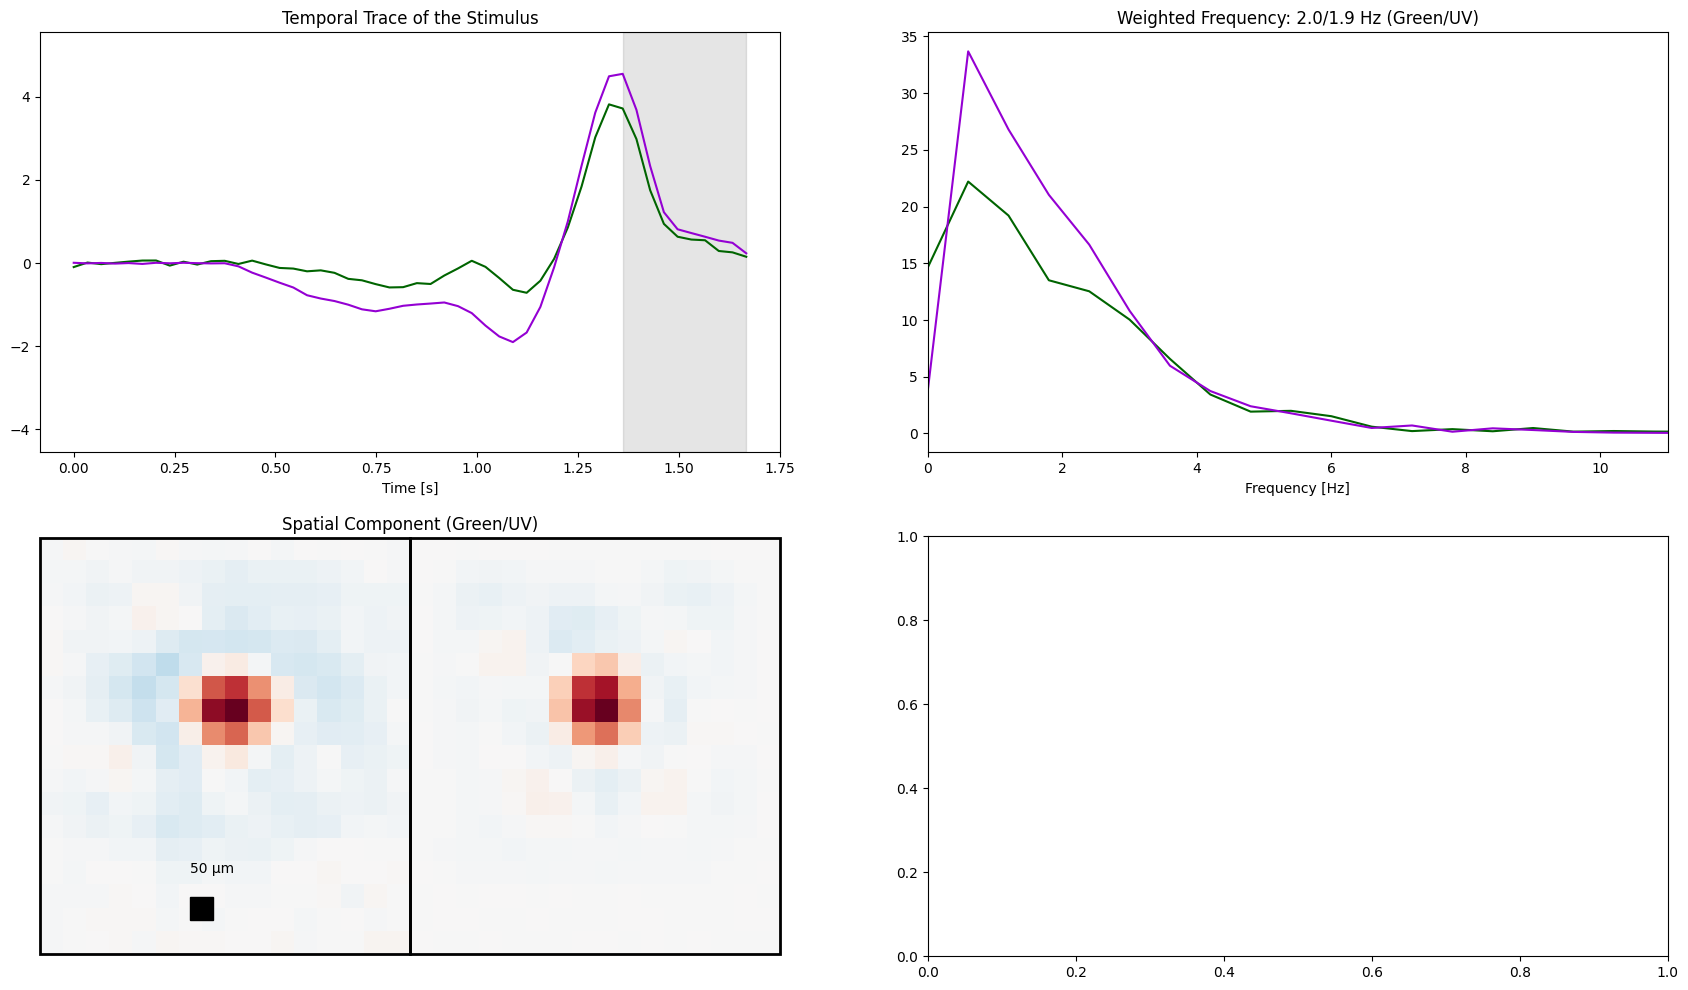

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=scaled_mei[0].cpu().numpy(),
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)

## Get response gradient across a grid of stimuli sampled around the MEI

In [11]:
example_neuron_objective = IncreaseObjective(
    ensemble_model, 
    neuron_indices=example_neuron, 
    data_key=session_id, 
    response_reducer=response_reducer
    )
gradient_grid, resp_grid, norm_grid, green_contrast_values, uv_contrast_values = \
            get_gradient_grid(
                scaled_mei, example_neuron_objective, step_size=.2
            )

# plot response gradient


In [15]:
from openretina.utils.plotting import plot_vector_field_resp_iso

In [16]:
rc_dict = {'figure.dpi': 300,
                     'figure.figsize': [2, 2],
                     'figure.frameon': False,
                     'font.size': 8,
                     'lines.markersize':1,
           'lines.linewidth':1,
           'lines.markeredgewidth': .5,
                     'legend.columnspacing': .5,
                     'legend.frameon': False,
                     'legend.markerscale': .4,
                     'legend.labelspacing': 0.1,
                     'legend.handletextpad': 0,
                     'legend.loc': "lower right",
           'axes.labelpad': 1.0,
            'xtick.major.pad': 1, 'ytick.major.pad': 1,
                
                     }

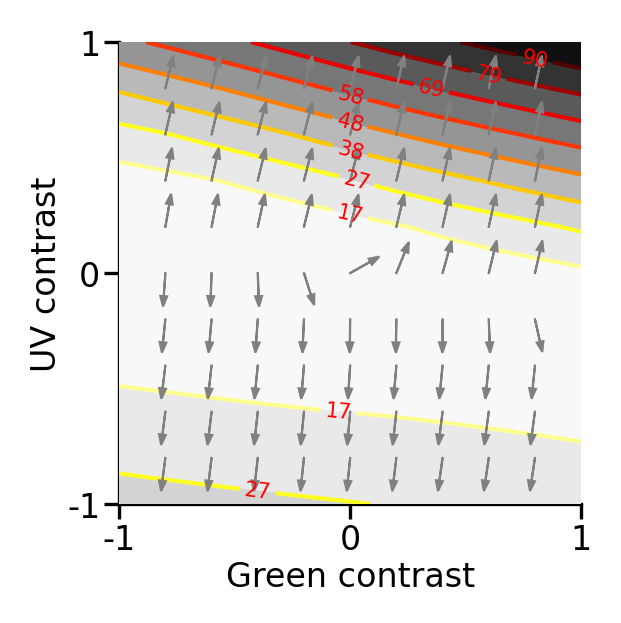

In [26]:
x = np.arange(-1, 1.2, .2)
fig = plot_vector_field_resp_iso(x, x, 
                            gradient_grid, 
                            resp_grid,
                            normalize_response=True, 
                            rc_dict=rc_dict);